In [2]:
import os, gc, random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm
from time import time, ctime

from sklearn.model_selection import KFold, GroupKFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR,  CosineAnnealingWarmRestarts
from torch.optim import Adam, AdamW
from torch.cuda.amp import autocast, GradScaler

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr, softmax

In [3]:
def get_logger(log_dir, logger_name="train_model.log"):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger_file = os.path.join(log_dir, logger_name)
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=logger_file, mode="a+")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
class ModelConfig:
    SEED = 20
    SPLIT_ENTROPY = 5.5
    MODEL_NAME = "Resnet_SeqGRU_EnhancedNO_NoReg"
    MODEL_BACKBONE = "Resnet_GRU"
    BATCH_SIZE = 32
    EPOCHS = 30
    EARLY_STOP_ROUNDS = 10
    GRADIENT_ACCUMULATION_STEPS = 1
    DROP_RATE = 0.15 # default: 0.1
    DROP_PATH_RATE = 0.25 # default: 0.2
    WEIGHT_DECAY = 0.01
    AMP = True
    PRINT_FREQ = 100
    NUM_WORKERS = 0 
    MAX_GRAD_NORM = 1e7
    REGULARIZATION = None

In [5]:
N_GPU = torch.cuda.device_count()
if N_GPU > 1:
    DEVICE = torch.device("cuda")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
elif N_GPU == 1:
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

print("Use Device: ", DEVICE)

Use Device:  cuda:0


In [6]:
class KagglePaths:
    OUTPUT_DIR = "/kaggle/working/"
    PRE_LOADED_EEGS = '/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTROGRAMS = '/kaggle/input/brain-spectrograms/specs.npy'
    TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    TRAIN_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/"
    TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
    TEST_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"


class LocalPaths:
    OUTPUT_DIR = "./outputs/"
    PRE_LOADED_EEGS = './inputs/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTROGRAMS = './inputs/brain-spectrograms/specs.npy'
    TRAIN_CSV = "./inputs/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "./inputs/hms-harmful-brain-activity-classification/train_eegs"
    TRAIN_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/train_spectrograms"
    TEST_CSV = "./inputs/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/test_spectrograms"
    TEST_EEGS = "./inputs/hms-harmful-brain-activity-classification/test_eegs"

PATHS = KagglePaths if os.path.exists("/kaggle") else LocalPaths

print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

BRAIN_ACTIVITY = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
TARGETS = [f"{lb}_vote" for lb in BRAIN_ACTIVITY]
TARGETS_PRED = [f"{lb}_pred" for lb in BRAIN_ACTIVITY]

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


In [7]:
EEF_FEAT_INDEX

{'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}

In [8]:
logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

# Load Data

In [9]:
def eeg_from_parquet(parquet_path: str, use_feature=EEG_FEAT_USE, display: bool = False) -> np.ndarray:
    # === Extract full length EEG Sequence ===
    # fill missing values with mean
    # first fill missing values with mean of each column
    # then if all values are missing, fill with 0
    eeg = pd.read_parquet(parquet_path, columns=use_feature)
    eeg = eeg.fillna(eeg.mean(skipna=True)).fillna(0)
    data = eeg.values.astype(np.float32)

    if display:
        fig, ax = plt.subplots(len(use_feature), 1, figsize=(10, 2*len(use_feature)), sharex=True)
        
        for i, feat in enumerate(use_feature):
            ax[i].plot(data[:, i], label=feat)
            ax[i].legend()
            ax[i].grid()
       
        name = parquet_path.split('/')[-1].split('.')[0]
        ax[0].set_title(f'EEG {name}',size=16)
        fig.tight_layout()
        plt.show()    
    return data

In [10]:
%%time
CREATE_EEGS = False
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs_full.npy')

if CREATE_EEGS:
    count = 0
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=False)
        ALL_EEG_SIGNALS[eeg_id] = data
        count += 1
    np.save("./inputs/eegs_full.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

CPU times: user 160 ms, sys: 1.94 s, total: 2.1 s
Wall time: 2.1 s


In [11]:
def get_non_overlap(df_csv, targets):
        
    agg_dicts = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'eeg_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
        'total_votes': 'sum',
        'entropy': 'mean',
        'is_hard': 'mean'
    }

    for col in targets:
        agg_dicts[col] = 'sum'

    df = df_csv.groupby(['eeg_id']).agg(agg_dicts).reset_index()

    col_names = [
        'spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 
        'patient_id', 'total_votes', 'entropy', 'is_hard'
        ] + targets

    df.columns = ["eeg_id"] + col_names
    df[targets] = df[targets].div(df['total_votes'], axis=0)
    
    df['target'] = df[targets].idxmax(axis=1)
    df['target'] = df['target'].apply(lambda x: x.split('_')[0])
    df['fold'] = -1
    
    return df

In [ ]:
# # Enhanced Samples Split 

# train_csv = pd.read_csv(PATHS.TRAIN_CSV)
# targets = train_csv.columns[-6:].tolist()

# raw_csv_len = len(train_csv)

# subset_counts = train_csv.groupby(['eeg_id']+targets).size().reset_index(name='subset_counts')
# train_csv = train_csv.merge(subset_counts, on=['eeg_id']+targets, how='left')

# tmp_cols = ['expert_consensus', 'eeg_label_offset_seconds', 'subset_counts']

# def sample_rule(x):
#     if (x['subset_counts'].min() > 3) & ((x['expert_consensus']!='Other').any()):
#         return x['eeg_label_offset_seconds'].sample(n=(x['subset_counts'].min()//3))
#     else:
#         return x['eeg_label_offset_seconds'].sample(n=1)

# train_samples = train_csv.groupby(['eeg_id']+targets)[tmp_cols].apply(sample_rule).reset_index()
# train_samples = train_samples.rename(columns={'eeg_label_offset_seconds': 'eeg_off_seconds'})
# train_samples.drop(columns=['level_7'], inplace=True)

# train_meta = train_csv.groupby(['eeg_id']+targets).agg({
#     'spectrogram_id': 'first',
#     'spectrogram_label_offset_seconds': ['min', 'max'],
#     'eeg_sub_id': 'count',
#     'eeg_label_offset_seconds': ['min', 'max'],
#     'patient_id': 'first',
# }).reset_index()

# agged_cols = [
#     'spectrogram_id', 'min', 'max', 'subset_counts', 'eeg_off_min', 'eeg_off_max', 'patient_id'
# ]
# train_meta.columns = ['eeg_id'] + targets + agged_cols
# train_meta = train_meta[['eeg_id'] + agged_cols + targets]

# train_meta['total_votes'] = train_meta[targets].sum(axis=1)
# train_meta['target'] = train_meta[targets].idxmax(axis=1).apply(lambda x: x.split('_')[0])
# train_meta['fold'] = -1

# K_FOLDS = 5
# kf = KFold(n_splits=K_FOLDS, shuffle=False)
# unique_eegs = train_meta['eeg_id'].unique()
# for fold, (_, valid_idx) in enumerate(kf.split(unique_eegs)):
#     train_meta.loc[train_meta['eeg_id'].isin(unique_eegs[valid_idx]), 'fold'] = fold

# train_all = train_samples.merge(train_meta, on=['eeg_id']+targets, how='left')

# train_all[targets] = train_all[targets].div(train_all['total_votes'], axis=0)

# train_all['stage'] = train_all['total_votes'].apply(lambda x: 1 if x < 10 else 2)

# train_all

In [29]:
# Konsantin's Split

train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

raw_csv_len = len(train_csv)

train_all = train_csv.drop_duplicates(subset=["eeg_id"] + targets).reset_index(drop=True)
print(f"Raw CSV: {raw_csv_len} | Unique CSV: {len(train_all)}")

train_all['total_votes'] = train_all[targets].sum(axis=1)

train_all.rename(columns={'eeg_label_offset_seconds': 'eeg_off_min', 'expert_consensus': 'target'}, inplace=True)
train_all.drop(columns=['eeg_sub_id', 'spectrogram_label_offset_seconds', 'spectrogram_sub_id', 'label_id'], inplace=True)

train_all[targets] = train_all[targets].div(train_all['total_votes'], axis=0)

pop_bands = [(1, 3), (4, 4), (5, 5), (6, 28)]
def classify_pops(x):
    for i, (lb, ub) in enumerate(pop_bands):
        if (x >= lb) & (x <= ub):
            return i

train_all['pop_id'] = train_all['total_votes'].apply(classify_pops)

K_FOLDS = 5
train_all['fold'] = -1
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(train_all, y=train_all['target'], groups=train_all['patient_id'])
for fold, (_, valid_idx) in enumerate(gkf_split):
    train_all.loc[valid_idx, 'fold'] = fold
    
train_pop2 = train_all[train_all['pop_id'] == 3].copy().reset_index(drop=True)

gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(train_pop2, y=train_pop2['target'], groups=train_pop2['patient_id'])
for fold, (_, valid_idx) in enumerate(gkf_split):
    train_pop2.loc[valid_idx, 'fold'] = fold
    
print(train_all.shape, train_pop2.shape)

train_all.head()

Raw CSV: 106800 | Unique CSV: 20183
(20183, 14) (6492, 14)


,eeg_id,eeg_off_min,spectrogram_id,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,pop_id,fold
0,1628180742,0.0,353733,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3,0,0
1,2277392603,0.0,924234,30539,GPD,0.0,0.0000,0.454545,0.000,0.090909,0.454545,11,3,3
2,722738444,0.0,999431,56885,LRDA,0.0,0.0625,0.000000,0.875,0.000000,0.062500,16,3,2
3,387987538,0.0,1084844,4264,LRDA,0.0,0.0000,0.000000,1.000,0.000000,0.000000,3,0,2
4,2175806584,0.0,1219001,23435,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3,0,2


In [30]:
for fold in range(K_FOLDS):
    train_eegs = train_all[train_all['fold'] != fold]['eeg_id']
    valid_eegs = train_all[train_all['fold'] == fold]['eeg_id']
    
    print(f"Leakage in Fold {fold}: ", train_eegs.isin(valid_eegs).sum())

Leakage in Fold 0:  0
Leakage in Fold 1:  0
Leakage in Fold 2:  0
Leakage in Fold 3:  0
Leakage in Fold 4:  0


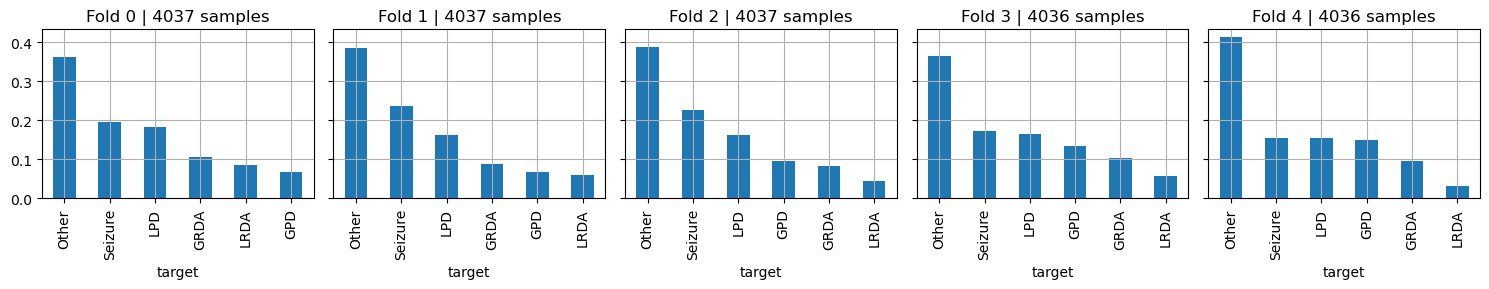

In [31]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
for i in range(5):
    tmp = train_all[train_all['fold']==i]
    (tmp['target'].value_counts() / len(tmp)).plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Fold {i} | {len(tmp)} samples')
    axes[i].grid()
plt.tight_layout()
plt.show()

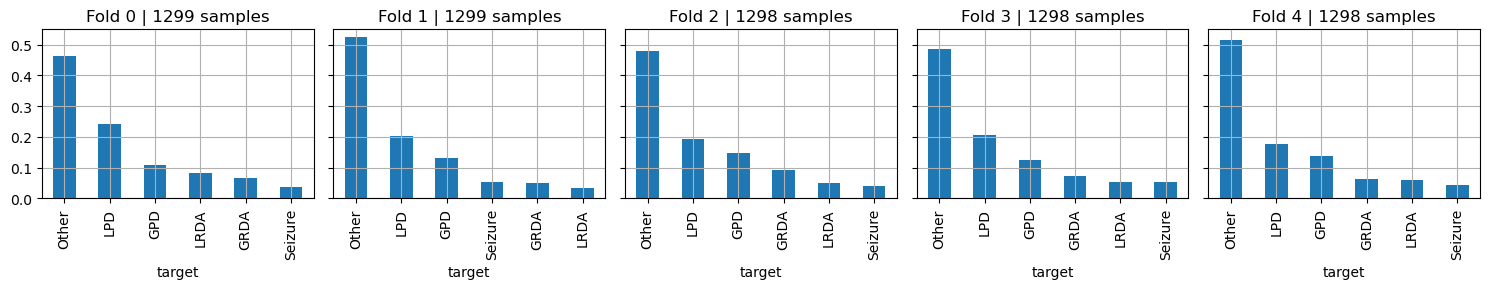

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
for i in range(5):
    tmp = train_pop2[(train_pop2['fold']==i)]
    (tmp['target'].value_counts() / len(tmp)).plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Fold {i} | {len(tmp)} samples')
    axes[i].grid()
plt.tight_layout()
plt.show()

In [35]:
# train_all[train_all['eeg_id']==2259539799] #['eeg_label_offset_seconds']#.groupby(['eeg_id']+targets).size().reset_index(name='subset_counts').sort_values('subset_counts')

In [37]:
# eeg_df = pd.read_parquet(f"{PATHS.TRAIN_EEGS}/2259539799.parquet")
# eeg_subset = eeg_df[EEG_FEAT_USE].values

# start_offsets = train_all[train_all['eeg_id']==2259539799]['eeg_off_seconds'].values

# fig, axes = plt.subplots(10, 1, figsize=(10, 30), sharex=True)

# idx = 1
# for i, ax in enumerate(axes):
#     data = eeg_subset[int(start_offsets[idx]*200):int(start_offsets[idx]*200)+10000, :]
#     seq = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
#     ax.plot(seq[::5], label=f'Fp1 - T3 ({idx})')
#     ax.legend()
#     idx += 20

# fig.tight_layout()
# plt.show()


In [ ]:
# # Chris Deotte's Method for Get_non_overlap

# train_csv = pd.read_csv(PATHS.TRAIN_CSV)
# targets = train_csv.columns[-6:].tolist()

# print("targets: ", targets)

# train_csv['total_votes'] = train_csv[targets].sum(axis=1)

# targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
# train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)
# train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: entropy(row.values+1e-5), axis=1)

# # split into easy and hard using totoal_votes
# train_csv['is_hard'] = (train_csv['total_votes']>10).astype(int) #(train_csv['entropy'] > 0.875).astype(int)

# train_all = get_non_overlap(train_csv, targets)
# print("train_all: ", train_all.shape)

# K_FOLDS = 5

# gkf = GroupKFold(n_splits=K_FOLDS)
# for fold, (train_idx, valid_idx) in enumerate(gkf.split(train_all, groups=train_all['patient_id'])):
#     train_all.loc[valid_idx, 'fold'] = fold

# print("train_all: ", train_all.shape)
# for fold in range(K_FOLDS):
#     train_size = train_all[train_all['fold'] != fold].shape[0]
#     valid_size = train_all[train_all['fold'] == fold].shape[0]
#     print(f"Fold {fold}: Train Size: {train_size}, Valid Size: {valid_size}")

# train_all.head(15)

# # Get Non Overlap for Hard EEGs

# hard_csv = train_csv[train_csv['is_hard'] == 1].copy().reset_index(drop=True)

# agg_dicts = {
#     'spectrogram_id': 'first',
#     'spectrogram_label_offset_seconds': ['min', 'max'],
#     'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1).values[0]],
#     'patient_id': 'first',
#     'total_votes': 'sum',
#     'entropy': 'mean',
#     'is_hard': 'mean'
# }

# for col in targets:
#     agg_dicts[col] = 'sum'

# train_hard = hard_csv.groupby(['eeg_id']+targets_prob).agg(agg_dicts).reset_index()

# col_names = [
#     'spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample',
#     'patient_id', 'total_votes', 'entropy', 'is_hard'
#     ] + targets

# train_hard.columns = ["eeg_id"] + targets_prob + col_names
# train_hard[targets] = train_hard[targets].div(train_hard['total_votes'], axis=0)
# train_hard.drop(targets_prob, axis=1, inplace=True)

# train_hard['target'] = train_hard[targets].idxmax(axis=1)
# train_hard['target'] = train_hard['target'].apply(lambda x: x.split('_')[0])
# train_hard['fold'] = -1

# print("train_hard: ", train_hard.shape)

# train_hard.head()

# K_FOLDS = 5

# for fold in range(K_FOLDS):
#     train_hard.loc[train_hard['eeg_id'].isin(train_all[train_all['fold'] == fold]['eeg_id']), 'fold'] = fold
    
# print(train_hard['fold'].value_counts())

In [ ]:
# Data Split
# train_csv = pd.read_csv(PATHS.TRAIN_CSV)
# targets = train_csv.columns[-6:].tolist()

# print("targets: ", targets)

# train_csv['total_votes'] = train_csv[targets].sum(axis=1)

# targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
# train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

# train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
# train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

# agg_dicts = {
#     'spectrogram_id': 'first',
#     'spectrogram_label_offset_seconds': ['min', 'max'],
#     'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)],
#     'patient_id': 'first',
#     'expert_consensus': 'first',
#     'total_votes': 'sum',
#     'entropy': 'mean',
#     'is_hard': 'mean'
# }

# for col in targets:
#     agg_dicts[col] = 'sum'

# train_all = train_csv.groupby(['eeg_id']+targets_prob).agg(agg_dicts).reset_index()

# col_names = [
#     'spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample', 
#     'patient_id', 'target', 'total_votes', 'entropy', 'is_hard'
#     ] + targets

# train_all.columns = ["eeg_id"] + targets_prob + col_names
# train_all.drop(targets_prob, axis=1, inplace=True)
# train_all[targets] = train_all[targets].div(train_all['total_votes'], axis=0)
# train_all['is_stage'] = 1
# train_all.loc[(train_all['total_votes']>10) | (train_all['entropy']<5.5), 'is_stage'] = 2

# train_all['sample_weight'] = 1.0

# print("train_all: ", train_all.shape)
# print("hard samples ratio: ", train_all[train_all['is_hard']==1].shape[0] / train_all.shape[0])
# print("easy samples ratio: ", train_all[train_all['is_hard']==0].shape[0] / train_all.shape[0])

# K_FOLDS = 5
# unique_eegs = train_all['eeg_id'].unique()
# kf = KFold(n_splits=K_FOLDS)

# train_all['fold'] = -1

# for fold, (train_index, valid_index) in enumerate(kf.split(unique_eegs)):
#     train_all.loc[train_all['eeg_id'].isin(unique_eegs[valid_index]), 'fold'] = fold

# print("train_all: ", train_all.shape)
# for fold in range(K_FOLDS):
#     train_size = train_all[train_all['fold'] != fold].shape[0]
#     valid_size = train_all[train_all['fold'] == fold].shape[0]
#     train_hard_size = train_all[(train_all['fold'] != fold) & (train_all['is_stage'] == 2)].shape[0]
#     valid_hard_size = train_all[(train_all['fold'] == fold) & (train_all['is_stage'] == 2)].shape[0]
#     print(f"Fold {fold}: All Size: {train_size} | {valid_size}, Hard Size: {train_hard_size} | {valid_hard_size}")

# train_all.head(15)

# Dataset

In [38]:
# Functional Utils
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [41]:
class EEGSeqDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', verbose=False):
        self.df = df
        self.mode = mode
        self.eegs = eegs
        self.verbose = verbose
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob = self.__data_generation(idx)
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)
    
    def __data_generation(self, index):
        row = self.df.iloc[index]

        if self.verbose:
            print(f"Row {index}", row[['eeg_id', 'eeg_off_min', 'target']].tolist())

        X = np.zeros((10_000, 8), dtype='float32')
        
        # start_sec = int((row['eeg_off_min'] + row['eeg_off_max']) // 2)
        eeg_seq = self.eegs[row.eeg_id]
        len_seq = eeg_seq.shape[0]
        start_at = int(row['eeg_off_min']) + (len_seq - 10_000) // 2 
        # !!! use randomly sampled offset !!!
        # start_sec = int(row['eeg_off_sample']) 
        data = eeg_seq[start_at:start_at+10_000, :]

        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        # !!! change to bandpass filter (low=0.5, hight=20, order=2) !!!
        X_list = [butter_bandpass_filter(X[:, i], .5, 20, 200, order=2) for i in range(8)]
        
        for i in range(8):
            X[:, i] = butter_lowpass_filter(X_list[i])

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)
        else:
            y_prob = np.zeros(6, dtype='float32')

        # downsample by 5
        return X[::5, :], y_prob 


X shape: torch.Size([16, 2000, 8])
y shape: torch.Size([16, 6])
tensor([0., 0., 0., 0., 0., 1.])
tensor([0.2500, 0.2500, 0.0000, 0.5000, 0.0000, 0.0000])
tensor([0., 0., 0., 0., 0., 1.])
tensor([1., 0., 0., 0., 0., 0.])


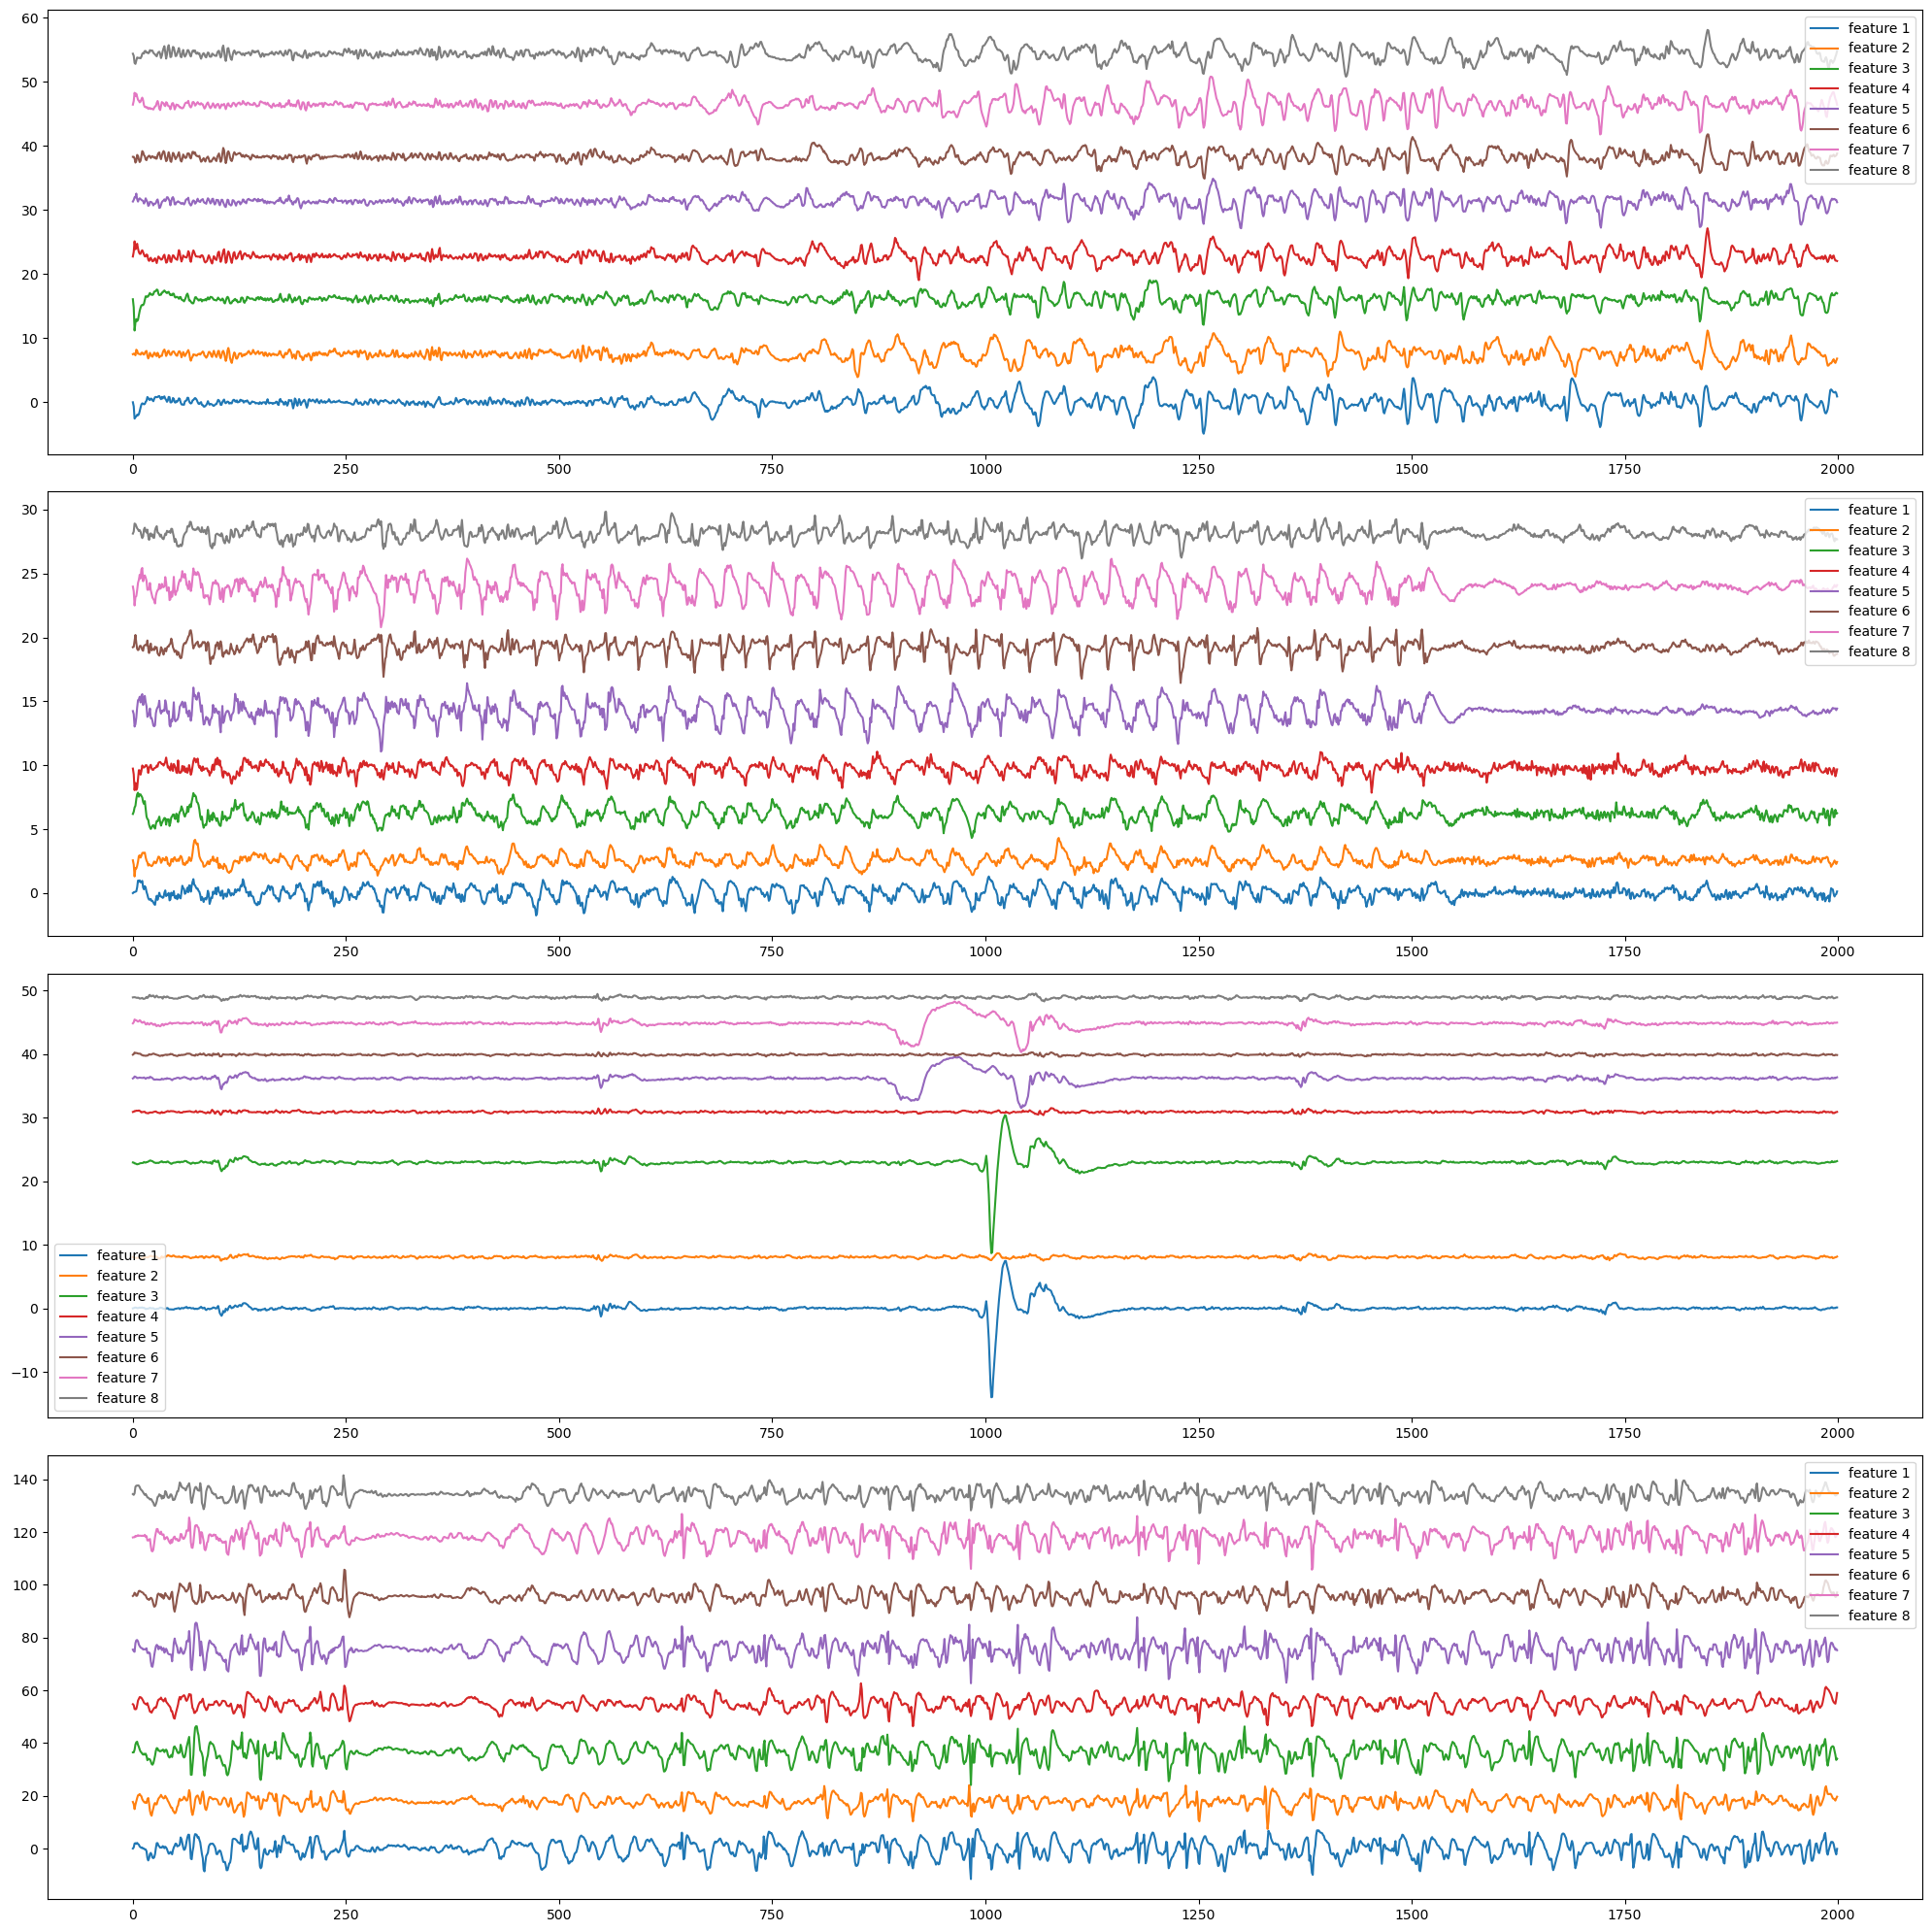

25911

In [45]:
# visualize the dataset

train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

for batch in train_loader:
    X, y = batch
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    fig, axes = plt.subplots(4, 1, figsize=(20, 20))
    ax_idx = 0
    for item in np.random.choice(range(X.shape[0]), 4):
        offset = 0
        for col in range(X.shape[-1]):
            if col != 0:
                offset -= X[item,:,col].min()
            axes[ax_idx].plot(np.arange(X.shape[1]), X[item,:,col]+offset, label=f'feature {col+1}')
            offset += X[item,:,col].max()
        print(y[item])
        # axes[ax_idx].set_title(f'Weight = {weights[item]}',size=14)
        axes[ax_idx].legend()
        ax_idx += 1
    fig.tight_layout()
    plt.show()
    break

del train_dataset, train_loader
torch.cuda.empty_cache()
gc.collect()

# Model

### Sequencial GRU Encoder

In [47]:
class SeqGRUEncoder(nn.Module):
    def __init__(self, in_channels, hidden_size=128, num_layers=2, bidirectional=True):
        super(SeqGRUEncoder, self).__init__()

        self.in_channels = in_channels

        # Initialize the GRU to have 128 hidden units per direction and to be bidirectional
        self.rnn = nn.GRU(
            input_size=in_channels, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional, 
            batch_first=True
        )
        
        # Initialize the attention mechanism
        if bidirectional:
            emb_dim = 2 * hidden_size
        else:
            emb_dim = hidden_size
        
        # self.attention_dense = nn.Linear(emb_dim, 1)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        rnn_out, _ = self.rnn(x)  # -> [batch, seq_len, emb_dim]
        identity = rnn_out[:, -1, :].squeeze(1)
        # scores = self.attention_dense(rnn_out).squeeze(-1)
        # scores = self.softmax(scores).unsqueeze(1)
        # pooled_out = torch.matmul(scores, identity).squeeze(1)
        # -> [batch_size, emb_dim]
        return identity

### Resnet 1D Encoder

In [48]:
class ResNet_1D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dilation=1, groups=1, dropout=0.0):
        super(ResNet_1D_Block, self).__init__()
        
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu_1 = nn.Hardswish()
        self.conv1 = nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding, 
            dilation=dilation, 
            groups=groups,
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.relu_2 = nn.Hardswish()
        self.conv2 = nn.Conv1d(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=1, 
            padding=padding, 
            dilation=dilation, 
            groups=groups,
            bias=False
        )
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=dilation)
        self.dropout = nn.Dropout(dropout, inplace=False)
        
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out
    
    
class ResNet_1D_Encoder(nn.Module):
    def __init__(self, kernels=[3,7,9,11], planes=24, in_channels=8, fixed_kernel_size=5, n_blocks=9, dilation=1, dropout=0.0):
        super(ResNet_1D_Encoder, self).__init__()
        
        self.kernels = kernels
        self.planes = planes
        
        self.parallel_conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=planes, 
                kernel_size=(kernel_size),
                stride=1, 
                padding=0,
                dilation=dilation,
                bias=False
            ) for kernel_size in kernels
        ])
        
        self.bn1 = nn.BatchNorm1d(num_features=planes)
        self.relu_1 = nn.SiLU()
        self.relu_2 = nn.SiLU()
        self.conv1 = nn.Conv1d(
            in_channels=planes, 
            out_channels=planes, 
            kernel_size=fixed_kernel_size, 
            stride=2,
            padding=2,
            dilation=dilation,
            groups=1, 
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(num_features=planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)

        self.resnet_layer = nn.Sequential(*[
            ResNet_1D_Block(
                in_channels=planes, 
                out_channels=planes, 
                kernel_size=fixed_kernel_size,
                stride=1, 
                padding=fixed_kernel_size//2, 
                downsampling=nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
                dropout=dropout
            ) for _ in range(n_blocks)
            ])
        
    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        # print("Resnet Input Shape: ", x.shape)
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
       
        out_sep = [ conv(x) for conv in self.parallel_conv ]
        out = torch.cat(out_sep, dim=2)

        out = self.bn1(out)
        out = self.relu_1(out)
        out = self.conv1(out)
        out = self.resnet_layer(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.avgpool(out)
        
        # Return the flattened features from the last convolutional layer
        features = out.reshape(out.shape[0], -1)
        return features


### Dilated Inception Wavenet Encoder

In [49]:
# from typing import List

# class DilatedInception(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int, kernel_sizes: List[int], dilation: int) -> None:
#         super().__init__()
#         assert out_channels % len(kernel_sizes) == 0, "`out_channels` must be divisible by the number of kernel sizes."
#         hidden_dim = out_channels // len(kernel_sizes)
#         self.convs = nn.ModuleList([
#             nn.Conv1d(in_channels, hidden_dim, k, padding='same', dilation=dilation)
#             for k in kernel_sizes
#         ])

#     def forward(self, x):
#         outputs = [conv(x) for conv in self.convs]
#         out = torch.cat(outputs, dim=1)
#         return out

# class GatedTCN(nn.Module):
#     def __init__(self, in_dim: int, h_dim: int, kernel_sizes: List[int], dilation_factor: int, dropout: float = 0.0) -> None:
#         super().__init__()
#         self.filt = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
#         self.gate = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         x_filt = torch.tanh(self.filt(x))
#         x_gate = torch.sigmoid(self.gate(x))
#         h = x_filt * x_gate
#         h = self.dropout(h)
#         return h

# class WaveBlock(nn.Module):
#     def __init__(self, n_layers: int, in_dim: int, h_dim: int, kernel_sizes: List[int]) -> None:
#         super().__init__()
#         self.dilation_rates = [2**i for i in range(n_layers)]
#         self.in_conv = nn.Conv1d(in_dim, h_dim, kernel_size=1)
#         self.gated_tcns = nn.ModuleList([
#             GatedTCN(h_dim, h_dim, kernel_sizes, dilation)
#             for dilation in self.dilation_rates
#         ])
#         self.skip_convs = nn.ModuleList([
#             nn.Conv1d(h_dim, h_dim, kernel_size=1)
#             for _ in range(n_layers)
#             ])
#         self._initialize_weights()

#     def _initialize_weights(self):
#         nn.init.xavier_uniform_(self.in_conv.weight, gain=nn.init.calculate_gain('relu'))
#         nn.init.zeros_(self.in_conv.bias)
#         for conv in self.skip_convs:
#             nn.init.xavier_uniform_(conv.weight, gain=nn.init.calculate_gain('relu'))
#             nn.init.zeros_(conv.bias)

#     def forward(self, x):
#         # x: (B, C, L)
#         x = self.in_conv(x)
#         x_skip = x
#         for gated_tcn, skip_conv in zip(self.gated_tcns, self.skip_convs):
#             x = gated_tcn(x)
#             x = skip_conv(x)
#             x_skip = x_skip + x
#         return x_skip

# class DilatedWaveNet(nn.Module):
#     """WaveNet architecture with dilated inception conv, enhanced with list comprehension for input processing."""

#     def __init__(self, kernel_sizes: List[int]) -> None:
#         super().__init__()
#         self.kernel_sizes = kernel_sizes
        
#         # Initialize wave blocks with specified kernel sizes
#         self.wave_module = nn.Sequential(
#             WaveBlock(9, 8, 128, self.kernel_sizes), #12
#             WaveBlock(6, 128, 256, self.kernel_sizes), #8
#             WaveBlock(3, 256, 512, self.kernel_sizes), #4
#             WaveBlock(1, 512, 512, self.kernel_sizes), #1
#         )
#         self.pool_layer = nn.AdaptiveAvgPool1d(1)

#     def forward(self, x) -> torch.Tensor:
#         # x: (B, L, C)
#         bs, seq_len, n_channels = x.shape
#         x = x.permute(0, 2, 1) # -> (B, C, L)
#         # Process different parts of the input with list comprehension
#         x = self.wave_module(x)
#         x = self.pool_layer(x) # ->(B, 512, 1)
#         x = x.reshape(bs, n_channels, -1).reshape(bs, n_channels//2, 2, 64)
#         features = x.mean(dim=2).reshape(bs, -1) # -> (16, 256)
# #         pooled_outputs = [(x[:, i:i+64] + x[:, i+64:i+128]) / 2 for i in range(0, n_channels, 2)]
# #         # Combine the pooled features and reshape for classification
# #         features = torch.cat(pooled_outputs, dim=1).reshape(bs, -1)
       
#         return features

### Dilated ResNet 1D Encoder

In [50]:
# class ResnetBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, dropout=0.0):
#         super(ResnetBlock, self).__init__()

#         self.bn1 = nn.BatchNorm1d(in_channels)
#         self.relu1 = nn.ReLU()
#         self.conv1 = nn.Conv1d(
#             in_channels, out_channels, kernel_size, 
#             stride=stride, 
#             padding=dilation*(kernel_size//2), 
#             dilation=dilation, 
#             bias=False)
#         self.drop1 = nn.Dropout(p=dropout)
#         self.bn2 = nn.BatchNorm1d(out_channels)
#         self.relu2 = nn.ReLU()
#         self.drop2 = nn.Dropout(p=dropout)
#         self.conv2 = nn.Conv1d(
#             out_channels, out_channels, kernel_size, 
#             stride=stride, 
#             padding=dilation*(kernel_size//2), 
#             dilation=dilation, 
#             bias=False)
        
#         self.bn3 = nn.BatchNorm1d(out_channels)
#         self.relu3 = nn.ReLU()
#         self.downsample = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

#     def forward(self, x):
#         identity = x
#         identity = self.downsample(identity)

#         out = self.bn1(x)
#         out = self.relu1(out)
#         out = self.drop1(out)
#         out = self.conv1(out)

#         out = self.bn2(out)
#         out = self.relu2(out)
#         out = self.drop2(out)
#         out = self.conv2(out)

#         out = self.downsample(out)

#         out += identity
#         out = self.bn3(out)
#         out = self.relu3(out)

#         return out

# class DilatedResnet(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, n_layers, expansion_factor=4):
#         super(DilatedResnet, self).__init__()

#         self.in_channels = in_channels
#         self.kernel_size = kernel_size
#         self.h_dim = out_channels // n_layers
        
#         fix_kernel_size = 5
#         self.conv1 = nn.Conv1d(
#             self.in_channels, self.h_dim, kernel_size=fix_kernel_size, stride=1, padding=fix_kernel_size//2
#             )

#         dilation_rates = [expansion_factor**i for i in range(n_layers)]

#         self.blocks = nn.ModuleList([
#             ResnetBlock(self.h_dim, self.h_dim, self.kernel_size, dilation=dilation)
#             for dilation in dilation_rates
#         ])

#     def forward(self, x):
#         x = self.conv1(x)
#         outputs = [ block(x) for block in self.blocks ]
#         output = torch.cat(outputs, dim=1)
        
#         return output

# class DilatedResnetEncoder(nn.Module):
#     def __init__(self, kernel_sizes=[3, 5, 7, 9], in_channels=8, planes=24, dilate_layers=[6,3,1], expansion_factor=4):
#         super(DilatedResnetEncoder, self).__init__()

#         self.in_channels = in_channels
#         self.planes = planes
#         self.kernel_sizes = kernel_sizes
#         self.dilate_layers = dilate_layers # must be 3 layers
#         self.expansion_factor = expansion_factor
        
#         # out_channels = self.planes * self.in_channels
#         # fix_kernel_size = 5
#         # self.conv1 = nn.Conv1d(
#         #     self.in_channels, out_channels, kernel_size=fix_kernel_size, stride=1, padding=fix_kernel_size//2
#         #     )
        
#         self.blocks = nn.ModuleList([
#             self._make_dilated_block(kernel_size)
#             for kernel_size in self.kernel_sizes
#         ])

#         bottleneck_in_channels = self.in_channels * self.planes * self.dilate_layers[1] * self.dilate_layers[2]
#         bottoleneck_out_channels = self.in_channels * self.planes

#         self.bottleneck = nn.Sequential(
#             nn.BatchNorm1d(num_features=bottleneck_in_channels),
#             nn.ReLU(),
#             nn.Conv1d(
#                 in_channels=bottleneck_in_channels,
#                 out_channels=bottoleneck_out_channels,
#                 kernel_size=1,
#                 stride=1,
#                 padding=0,
#                 bias=False
#             )
#         )
        
#         self.pooling = nn.AdaptiveAvgPool1d(1)
#         # self.blocks = nn.ModuleList([
#         #     nn.Sequential(*[
#         #         ResidualBlock(
#         #             out_channels, out_channels, kernel_size, dilation=dilation
#         #         ) for dilation in self.dilate_layers
#         #     ])
#         #     for kernel_size in self.kernel_sizes
#         # ])

#     def _make_dilated_block(self, kernel_size):
#         out_channel_1 = self.in_channels * self.planes
#         block_1 = DilatedResnet(self.in_channels, out_channel_1, kernel_size, self.dilate_layers[0], self.expansion_factor)

#         out_channel_2 = out_channel_1 * self.dilate_layers[1]
#         block_2 = DilatedResnet(out_channel_1, out_channel_2, kernel_size, self.dilate_layers[1], self.expansion_factor)

#         out_channel_3 = out_channel_2 * self.dilate_layers[2]
#         block_3 = DilatedResnet(out_channel_2, out_channel_3, kernel_size, self.dilate_layers[2], self.expansion_factor)

#         return nn.Sequential(block_1, block_2, block_3)
        
    
#     def forward(self, x):
#         # <- # [batch_size, seq_len=2000, in_channels=8]
#         x = x.permute(0, 2, 1)
#         # x = self.conv1(x)
#         outputs = [ block(x) for block in self.blocks ]
#         outputs = [ self.bottleneck(out) for out in outputs ]
#         output = torch.cat(outputs, dim=1)
#         output = self.pooling(output).squeeze(-1)
        
#         return output

### EEGSeqClassifier 

In [51]:
class EEGSeqClassifier(nn.Module):
    def __init__(self, config, num_classes=6):
        super(EEGSeqClassifier, self).__init__()

        self.seqgru = SeqGRUEncoder(in_channels=8, hidden_size=128, num_layers=2, bidirectional=True)
        self.resnet = ResNet_1D_Encoder(
            kernels=[3, 5, 7, 9, 11], 
            planes=24, 
            in_channels=8, 
            fixed_kernel_size=5, 
            n_blocks=9, 
            dropout=0.0
        )
        # self.wavenet = DilatedWaveNet(kernel_sizes=[2, 3, 6, 7])
        # self.dilated_resnet = DilatedResnetEncoder(
        #     kernel_sizes=[3, 5, 7, 9], 
        #     in_channels=8, 
        #     planes=24, 
        #     dilate_layers=[6,3,1], 
        #     expansion_factor=4
        # )

        hidden_dim = 304   #768 #72 + 256 #+ 256
        self.predict_head = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]

        resnet_out = self.resnet(x)
        seqgru_out = self.seqgru(x)
        # wavenet_out = self.wavenet(x)
        features = torch.cat([seqgru_out, resnet_out], dim=1)
        # features = self.dilated_resnet(x)
        logits = self.predict_head(features)
        return logits

In [52]:
train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

model = EEGSeqClassifier(ModelConfig, num_classes=6)
model.to(DEVICE)
for i, batch in enumerate(train_loader):
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    y_pred = model(X)
    print(y_pred.shape)
    break 

del model, train_dataset, train_loader, X, y
torch.cuda.empty_cache()
gc.collect()

X shape: torch.Size([16, 2000, 8])
y shape: torch.Size([16, 6])
torch.Size([16, 6])


0

In [53]:
!nvidia-smi

Thu Apr  4 15:12:01 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 26%   36C    P2    56W / 260W |   1823MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Train

In [54]:
import warnings
warnings.filterwarnings("ignore")

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class Trainer:

    def __init__(self, model, config, logger):

        self.model = model
        self.logger = logger
        self.config = config
        
        self.early_stop_rounds = config.EARLY_STOP_ROUNDS
        self.early_stop_counter = 0
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()
        self.gamma = config.REGULARIZATION
        
        # self.criterion = nn.KLDivLoss(reduction="batchmean")
    
    def criterion(self, y_pred, y_true, weights=None, mode='train'):
        kl_loss = self.kl_div_loss(F.log_softmax(y_pred, dim=1), y_true)
        if (self.gamma is not None) & (mode == 'train'):
            softmax_probs = F.softmax(y_pred, dim=1)  # Compute softmax probabilities
            entropy_loss = -(softmax_probs * torch.log(softmax_probs + 1e-9)).sum(dim=1).mean(dim=0) # Compute entropy, add epsilon to avoid log(0)
            return kl_loss - self.gamma * entropy_loss
        else:
            return kl_loss
        
        #.sum(dim=1)  # Compute KL divergence
        # if (self.gamma is not None) & (mode == 'train'):
        #     softmax_probs = F.softmax(y_pred, dim=1)  # Compute softmax probabilities
        #     self_entropy_loss = -(softmax_probs * torch.log(softmax_probs + 1e-9)).sum(dim=1) # Compute entropy, add epsilon to avoid log(0)
        #     return (weights * (kl_loss - self.gamma * self_entropy_loss)).sum() / weights.sum()
        # else:
        #     return (weights * kl_loss).sum() / weights.sum()
        
    def train(self, train_loader, valid_loader, from_checkpoint=None):

        self.optimizer = AdamW(self.model.parameters(), lr=8e-3, weight_decay=self.config.WEIGHT_DECAY)

        self.scheduler =  CosineAnnealingWarmRestarts( 
            self.optimizer,
            T_0=20,
            eta_min=1e-6,
            T_mult=1,
            last_epoch=-1
        )
        # #OneCycleLR(
        #     self.optimizer,
        #     max_lr=1e-4,
        #     epochs=self.config.EPOCHS,
        #     steps_per_epoch=len(train_loader),
        #     pct_start=0.1,
        #     anneal_strategy="cos",
        #     final_div_factor=100,
        # )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("inf")
        loss_records = {"train": [], "valid": []}

        for epoch in range(self.config.EPOCHS):
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False)

            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch

            info = f"{'-' * 100}\nEpoch {epoch + 1} - "
            info += f"Average Loss: (train) {train_loss:.4f}; (valid) {valid_loss:.4f} | Time: {elapsed:.2f}s"
            self.logger.info(info)

            if valid_loss < best_loss:
                best_loss = valid_loss
                best_weights = self.model.state_dict()
                best_preds = valid_preds
                self.logger.info(f"Best model found in epoch {epoch + 1} | valid loss: {best_loss:.4f}")
                self.early_stop_counter = 0
            
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.early_stop_rounds:
                    self.logger.info(f"Early stopping at epoch {epoch + 1}")
                    break

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.AMP)
        loss_meter, predicts_record = AverageMeter(), []

        start = time()
        pbar = tqdm(dataloader, total=len(dataloader), unit="batch", desc=f"{mode} [{epoch_id}]")
        for step, (X, y) in enumerate(pbar):
            X, y = X.to(self.device), y.to(self.device)

            if is_train:
                with autocast(enabled=self.config.AMP):
                    y_pred = self.model(X)
                    loss = self.criterion(y_pred, y)
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.MAX_GRAD_NORM)
                if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
            else:
                with torch.no_grad():
                    y_pred = self.model(X)
                    loss = self.criterion(y_pred, y, mode='valid')
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                
                predicts_record.append(y_pred.to('cpu').numpy())
            
            loss_meter.update(loss.item(), y.size(0))
            end = time()

            if (step % self.config.PRINT_FREQ == 0) or (step == (len_loader - 1)):
                lr = self.scheduler.get_last_lr()[0]
                info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} Loss: {loss_meter.avg:.4f}"
                if is_train:
                    info += f" Grad: {grad_norm:.4f} LR: {lr:.4e}"
                info += f" | Elapse: {end - start:.2f}s"
                print(info)

        if not is_train:
            predicts_record = np.concatenate(predicts_record)
            
        return loss_meter.avg, predicts_record


In [55]:
def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = EEGSeqDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train")
    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=None, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    if checkpoint is not None:
        print(f"Loading model from checkpoint: {checkpoint}")

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [56]:
def evaluate_oof(oof_df):
    '''
    Evaluate the out-of-fold dataframe using KL Divergence (torch and kaggle)
    '''
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[TARGETS].values.astype('float32'))
    preds = F.log_softmax(
        torch.tensor(oof_df[TARGETS_PRED].values.astype('float32'), requires_grad=False),
        dim=1
    )
    kl_torch = kl_loss(preds, labels).item()

    return kl_torch

In [57]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

In [ ]:
# Major Train Loop
# ================== Logger ==================
logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Prepare Training ==================
oof_stage_1, oof_stage_2 = pd.DataFrame(), pd.DataFrame()
loss_history_1, loss_history_2 = [], []
t_start = time()

for fold in range(0, K_FOLDS):
    tik_total = time()
    tik = time()

    # ================== Stage 1: Train ====================
    model = EEGSeqClassifier(ModelConfig, num_classes=6)
    
    valid_folds = train_all[(train_all['fold'] == fold) ].reset_index(drop=True)
    train_folds = train_all[(train_all['fold'] != fold) ].reset_index(drop=True)

    train_size, valid_size = train_folds.shape[0], valid_folds.shape[0]

    ## STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold}\n{'=' * 100}")
    logger.info(f"- Stage 1 | Train: {train_size}; Valid: {valid_size} -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)

    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

    # ================== Stage 2: Train ====================
    tik = time()
    model = EEGSeqClassifier(ModelConfig, num_classes=6)

    valid_folds_2 = train_pop2[(train_pop2['fold'] == fold)].reset_index(drop=True)
    train_folds_2 = train_pop2[(train_pop2['fold'] != fold)].reset_index(drop=True)

    train_size, valid_size = train_folds_2.shape[0], valid_folds_2.shape[0]
    
    #check leakage
    print(f"Leakage Check:", valid_folds_2['eeg_id'].isin(train_folds['eeg_id']).sum())

    ## STAGE 2
    logger.info(f"- Stage 2 | Train: {train_size}; Valid: {valid_size} -")

    checkpoint = os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth")

    valid_predicts, loss_records = train_fold(
        model, fold, train_folds_2, valid_folds_2, logger, stage=2, checkpoint=checkpoint)
    
    loss_history_2.append(loss_records)
    valid_folds_2[TARGETS_PRED] = valid_predicts
    kl_loss_torch = evaluate_oof(valid_folds_2)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)

    oof_stage_2 = pd.concat([oof_stage_2, valid_folds_2], axis=0).reset_index(drop=True)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

    logger.info(f"Fold {fold} Elapse: {(time() - tik_total) / 60:.2f} min")

info = f"{'=' * 100}\nTraining Complete!\n"
cv_results_1 = evaluate_oof(oof_stage_1)
cv_results_2 = evaluate_oof(oof_stage_2)
info += f"CV Result: Stage 1: {cv_results_1} | Stage 2: {cv_results_2}\n"
info += f"Elapse: {(time() - t_start) / 60:.2f} min \n{'=' * 100}"
logger.info(info)

In [ ]:
# plot loss history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, loss in enumerate(loss_history_1):
    ax1.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax1.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

for i, loss in enumerate(loss_history_2):
    ax2.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax2.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax1.set_title("Stage 1 Loss")
ax2.set_title("Stage 2 Loss")

for ax in (ax1, ax2):
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

fig.tight_layout()
fig.savefig(Path(PATHS.OUTPUT_DIR) / f"{ModelConfig.MODEL_NAME}_loss_history.png")
plt.show()

In [ ]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
oof_samples = oof_df.sample(axes.size)

for i, ax in enumerate(axes.flatten()):
    row = oof_samples.iloc[i]
    x = np.arange(6)
    ax.plot(x, row[TARGETS].T, marker="o", ls="-", label="True")
    ax.plot(x, row[TARGETS_PRED].T, marker="*", ls="--", label="Predicted")
    ax.set_title(f"{row['target']} | KL Loss: {row['kl_loss']:.4f}")
    ax.legend()
    
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_samples.png")
plt.show()

In [ ]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
oof_samples = oof_df.sample(axes.size)

for i, ax in enumerate(axes.flatten()):
    row = oof_samples.iloc[i]
    x = np.arange(6)
    ax.plot(x, row[TARGETS].T, marker="o", ls="-", label="True")
    ax.plot(x, row[TARGETS_PRED].T, marker="*", ls="--", label="Predicted")
    ax.set_title(f"{row['target']} | KL Loss: {row['kl_loss']:.4f}")
    ax.legend()
    
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_samples.png")
plt.show()

In [ ]:
oof_stage_2_full = pd.DataFrame()

for fold in range(1):

    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)

    # predict labels using stage-2 models
    model = EEGSeqClassifier(ModelConfig, num_classes=6)
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_2.pth"
    )

    model.load_state_dict(torch.load(check_point, map_location=DEVICE))

    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    model.to(DEVICE)
    model.eval()

    valid_predicts = []
    with torch.no_grad():
        for X, y in valid_loader:
            X = X.to(DEVICE)
            y_pred = model(X)
            valid_predicts.append(y_pred.to('cpu').numpy())

    valid_predicts = np.concatenate(valid_predicts)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2_full = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)

    del valid_dataset, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    oof_stage_2_full.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2_full.csv"), index=False)

cv_results = evaluate_oof(oof_stage_2_full)
logger.info(f"{'=' * 100}\nCV Result (Stage 2 Full): {cv_results}\n{'=' * 100}")


In [ ]:
csv_path = f'./outputs/Resnet_SeqGRU_ChrisNO_NoReg_oof_2_full.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()